<a href="https://colab.research.google.com/github/Divyaanshvats/FIDROX_ASSIGNMENTS/blob/main/Autoencoders_FIDROX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AccessAI: Detecting Anomalous Swipe Behavior in Physical Access Control Systems(using AutoEncoders)**

# **IMPORT ALL THE REQUIRE LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os
np.random.seed(42)
random.seed(42)
NUM_DAYS = 30
SWIPES_PER_DAY = 1000
TOTAL_RECORDS = NUM_DAYS * SWIPES_PER_DAY
user_ids = [f"U{str(i).zfill(3)}" for i in range(1, 101)]
doors = {
    "D01": "Main Entrance",
    "D02": "East Wing",
    "D03": "Server Room",# restricted
    "D04": "HR Department",
    "D05": "Rooftop Access",# rarely used
    "D06": "Finance Room",
    "D07": "Cafeteria",
    "D08": "Basement Storage",# rarely used
}

# **RANDOM GENERATION OF DATASET(SAME AS DBSCAN)**

In [2]:
data = []
start_date = datetime(2025, 5, 1)
for i in range(TOTAL_RECORDS):
    current_date = start_date + timedelta(days=i // SWIPES_PER_DAY)
    if np.random.rand() < 0.8:
        hour = np.random.randint(8, 19)
    else:
        hour = np.random.choice([0, 1, 2, 3, 4, 22, 23])

    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    timestamp = current_date.replace(hour=hour, minute=minute, second=second)
    user = random.choice(user_ids)
    door = random.choices(list(doors.keys()), weights=[25, 20, 5, 15, 2, 10, 20, 3])[0]
    direction = random.choice(["IN", "OUT"])
    result = "Success" if np.random.rand() > 0.05 else "Failed"
    if np.random.rand() < 0.01:
        for _ in range(5):
            anomaly_timestamp = timestamp + timedelta(seconds=random.randint(1, 30))
            data.append([anomaly_timestamp, user, door, doors[door], direction, "Failed"])

    data.append([timestamp, user, door, doors[door], direction, result])
df = pd.DataFrame(data, columns=["Timestamp", "UserID", "DoorID", "DoorName", "Direction", "Result"])
df.head()

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success


In [3]:
output_path = "/mnt/data/AccessAI_Simulated_Swipe_Logs.csv"
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(output_path, index=False)
output_path

'/mnt/data/AccessAI_Simulated_Swipe_Logs.csv'

In [4]:
df = pd.read_csv("/mnt/data/AccessAI_Simulated_Swipe_Logs.csv")
df.head(3)

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success


In [5]:
len(df)#length of dataset

31505

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Step 1: Feature engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['IsOddHour'] = df['Hour'].apply(lambda x: 1 if (x < 6 or x > 21) else 0)
df['IsRestrictedDoor'] = df['DoorName'].isin(['Server Room', 'Rooftop Access', 'Basement Storage']).astype(int)
df['IsFailed'] = (df['Result'] == 'Failed').astype(int)
df['DirectionEncoded'] = (df['Direction'] == 'IN').astype(int)

# Encode DoorName (categorical)
door_encoder = LabelEncoder()
df['DoorEncoded'] = door_encoder.fit_transform(df['DoorName'])

# Select features for autoencoder
feature_cols = ['Hour', 'IsOddHour', 'IsRestrictedDoor', 'DirectionEncoded', 'DoorEncoded']
X = df[feature_cols].values

# Normalize features (0–1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of final input:", X_scaled.shape)

Shape of final input: (31505, 5)


# **The Autoencoder Architecture**

In [7]:
import torch
import torch.nn as nn

# Autoencoder Model
class SwipeAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SwipeAutoencoder, self).__init__()


        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.ReLU(),
            nn.Linear(3,2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2,3),
            nn.ReLU(),
            nn.Linear(3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
from torch.utils.data import DataLoader, TensorDataset
X_train = df[df['IsFailed'] == 0][feature_cols]
X_train_scaled = scaler.transform(X_train)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [9]:
input_dim = X_train_tensor.shape[1]
model = SwipeAutoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 22
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [1/22], Loss: 0.152704
Epoch [2/22], Loss: 0.136380
Epoch [3/22], Loss: 0.130217
Epoch [4/22], Loss: 0.127451
Epoch [5/22], Loss: 0.126129
Epoch [6/22], Loss: 0.125469
Epoch [7/22], Loss: 0.125133
Epoch [8/22], Loss: 0.124953
Epoch [9/22], Loss: 0.124861
Epoch [10/22], Loss: 0.124812
Epoch [11/22], Loss: 0.124790
Epoch [12/22], Loss: 0.124779
Epoch [13/22], Loss: 0.124774
Epoch [14/22], Loss: 0.124773
Epoch [15/22], Loss: 0.124770
Epoch [16/22], Loss: 0.124774
Epoch [17/22], Loss: 0.124772
Epoch [18/22], Loss: 0.124772
Epoch [19/22], Loss: 0.124771
Epoch [20/22], Loss: 0.124773
Epoch [21/22], Loss: 0.124772
Epoch [22/22], Loss: 0.124772


In [11]:
X_all = df[feature_cols].values
X_all_scaled = scaler.transform(X_all)
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)

In [12]:
model.eval()
with torch.no_grad():
    reconstructed = model(X_all_tensor)
    mse = torch.mean((X_all_tensor - reconstructed) ** 2, dim=1).numpy()

In [13]:
df['Recon_Error'] = mse

# THRESHOLD(95th Percentile)
threshold = np.percentile(mse, 95)
df['Autoencoder_Anomaly'] = (df['Recon_Error'] > threshold).astype(int)

print(f"Anomalies flagged by autoencoder: {df['Autoencoder_Anomaly'].sum()}")

Anomalies flagged by autoencoder: 1541


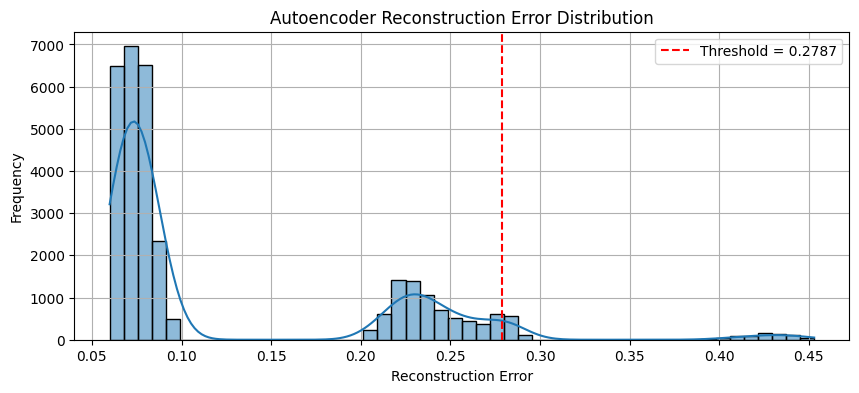

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df['Recon_Error'], bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title('Autoencoder Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

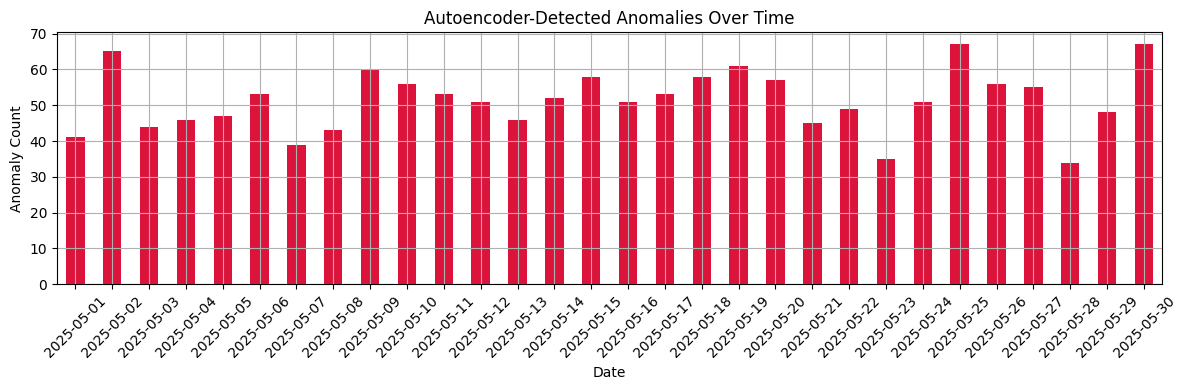

In [15]:
df['Date'] = df['Timestamp'].dt.date
timeline = df[df['Autoencoder_Anomaly'] == 1].groupby('Date').size()

plt.figure(figsize=(12, 4))
timeline.plot(kind='bar', color='crimson')
plt.title('Autoencoder-Detected Anomalies Over Time')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [16]:
df[df['Autoencoder_Anomaly'] == 1].sort_values('Recon_Error', ascending=False).head(10)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsOddHour,IsRestrictedDoor,IsFailed,DirectionEncoded,DoorEncoded,Recon_Error,Autoencoder_Anomaly,Date
7274,2025-05-07 00:27:55,U068,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-07
9710,2025-05-10 00:41:59,U016,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-10
5177,2025-05-05 00:54:42,U047,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-05
9925,2025-05-10 00:22:50,U049,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-10
24199,2025-05-24 00:42:01,U002,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-24
23854,2025-05-23 00:19:47,U057,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-23
24556,2025-05-24 00:48:05,U021,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-24
30977,2025-05-30 00:10:21,U048,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-30
8281,2025-05-08 00:01:25,U064,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-08
8167,2025-05-08 00:44:43,U054,D03,Server Room,IN,Success,0,1,1,0,1,7,0.453008,1,2025-05-08
